In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [3]:
# make our generative model with two components, a fair die and a
# loaded die
gen_model = hmm.MultinomialHMM(n_components=2, random_state=99)

In [4]:
# the first state is the fair die so let's start there so no one
# catches on right away
gen_model.startprob_ = np.array([1.0, 0.0])

In [5]:
# now let's say that we sneak the loaded die in:
# here, we have a 95% chance to continue using the fair die and a 5%
# chance to switch to the loaded die
# when we enter the loaded die state, we have a 90% chance of staying
# in that state and a 10% chance of leaving
gen_model.transmat_ = np.array([[0.95, 0.05],[0.1, 0.9]])

# now let's set the emission means:
# the first state is a fair die with equal probabilities and the
# second is loaded by being biased toward rolling a six
gen_model.emissionprob_ = np.array([[1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6], [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 2]])

C:\Users\rrahe\AppData\Local\Temp\ipykernel_4084\2427948461.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


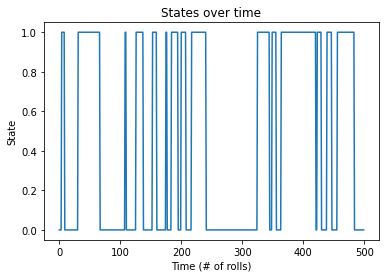

In [6]:
rolls, gen_states = gen_model.sample(30000)

# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:500])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

C:\Users\rrahe\AppData\Local\Temp\ipykernel_4084\3961693798.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


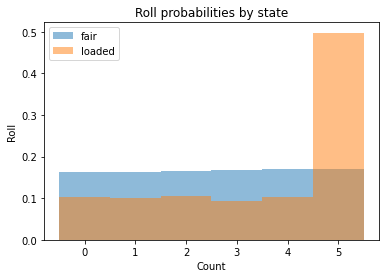

In [7]:
# plot rolls for the fair and loaded states
fig, ax = plt.subplots()
ax.hist(rolls[gen_states == 0], label='fair', alpha=0.5, bins=np.arange(7) - 0.5, density=True)
ax.hist(rolls[gen_states == 1], label='loaded', alpha=0.5, bins=np.arange(7) - 0.5, density=True)
ax.set_title('Roll probabilities by state')
ax.set_xlabel('Count')
ax.set_ylabel('Roll')
ax.legend()
fig.show()

In [8]:
# split our data into training and validation sets (50/50 split)
X_train = rolls[:rolls.shape[0] // 2]
X_validate = rolls[rolls.shape[0] // 2:]

In [9]:
# check optimal score
gen_score = gen_model.score(X_validate)

In [14]:
best_score = best_model = None
n_fits = 10
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.MultinomialHMM(
        n_components=2, random_state=idx,
        init_params='se')  # don't init transition, set it below
    # we need to initialize with random transition matrix probabilities
    # because the default is an even likelihood transition
    # we know transitions are rare (otherwise the casino would get caught!)
    # so let's have an Dirichlet random prior with an alpha value of
    # (0.1, 0.9) to enforce our assumption transitions happen roughly 10%
    # of the time
    model.transmat_ = np.array([np.random.dirichlet([0.9, 0.1]),
                                np.random.dirichlet([0.1, 0.9])])
    model.fit(X_train)
    score = model.score(X_validate)
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'\nGenerated score: {gen_score}\nBest score:      {best_score}')
print(f'\nTransmission Matrix Generated:\n{gen_model.transmat_.round(3)}\n' f'Transmission Matrix Recovered:\n{best_model.transmat_.round(3)}\n')
print(f'Emission Matrix Generated:\n{gen_model.emissionprob_.round(3)}\n' f'Emission Matrix Recovered:\n{best_model.emissionprob_.round(3)}\n')

Model #0	Score: -26391.3688134072
Model #1	Score: -26395.55036572371
Model #2	Score: -26405.788668012425
Model #3	Score: -26396.290282611586
Model #4	Score: -26395.550365729432
Model #5	Score: -26375.803386308733
Model #6	Score: -26395.484479933773
Model #7	Score: -26300.67439789695
Model #8	Score: -26265.231805566247
Model #9	Score: -26395.550355030126

Generated score: -26230.575868403906
Best score:      -26265.231805566247

Transmission Matrix Generated:
[[0.95 0.05]
 [0.1  0.9 ]]
Transmission Matrix Recovered:
[[0.88  0.12 ]
 [0.275 0.725]]

Emission Matrix Generated:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.1   0.1   0.1   0.1   0.1   0.5  ]]
Emission Matrix Recovered:
[[0.169 0.172 0.171 0.171 0.169 0.149]
 [0.079 0.075 0.082 0.079 0.096 0.589]]



In [11]:
# use the Viterbi algorithm to predict the most likely sequence of states
# given the model
states = best_model.predict(rolls)
states

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

C:\Users\rrahe\AppData\Local\Temp\ipykernel_4084\2003059249.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


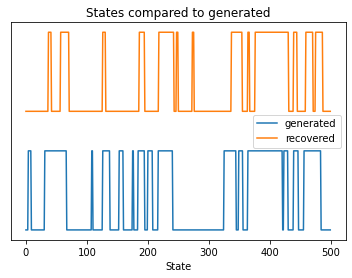

In [12]:
# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(gen_states[:500], label='generated')
ax.plot(states[:500] + 1.5, label='recovered')
ax.set_yticks([])
ax.set_title('States compared to generated')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
ax.legend()
fig.show()
